
# RCAN Baseline Training (DeepLense-style)

This notebook trains a **Residual Channel Attention Network (RCAN)** baseline on your paired LR/HR `.npy` datasets:

- **LR file**: `lr_all_lsst_20k.npy`
- **HR file**: `hr_all_lsst_20k.npy`

The code assumes *paired ordering* across LR/HR arrays. Images are **47×47**; if shapes differ, the loader will **pad/crop to 47** safely.

**Highlights**
- Pure PyTorch RCAN (RCAB + channel attention)
- AMP (`torch.cuda.amp`) + gradient clipping
- PSNR/SSIM metrics (SSIM torch fallback; `skimage` optional)
- Checkpointing & auto-resume
- Simple train/val split (shuffle + seed)
- Optional padding to 47×47


In [1]:

#@title 0) Environment check
import os, sys, math, random, time, json, shutil
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from dataloaders import *


Python: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA RTX A5000


In [2]:

#@title 1) Config
from dataclasses import dataclass, asdict

@dataclass
class Config:
    # Paths (edit to point to your files on the cluster)
    lr_path: str = "/home/imglab/Sasha/DeepLense/grav_lens_diff/lr_all_lsst_20k.npy"   # change if needed
    hr_path: str = "/home/imglab/Sasha/DeepLense/grav_lens_diff/hr_all_lsst_20k.npy"   # change if needed
    out_dir: str = "./rcan_runs/baseline_rcan"

    # Data
    target_size: int = 47         # pad or center-crop to this size
    normalize: bool = True        # per-image mean/std normalize
    train_frac: float = 0.9       # train/val split
    shuffle_seed: int = 42
    augment: bool = False         # light augments (flip)

    # Model (RCAN-ish small baseline)
    n_feats: int = 64
    n_resblocks: int = 10         # RCAB per group
    n_groups: int = 5             # residual groups
    reduction: int = 16           # channel attention reduction

    # Optimization
    batch_size: int = 128
    num_workers: int = 4
    lr: float = 2e-5
    weight_decay: float = 0.0
    epochs: int = 100
    warmup_epochs: int = 5
    grad_clip: float = 1.0
    use_amp: bool = True

    # Logging / checkpoints
    ckpt_every: int = 5
    val_every: int = 1
    max_keep: int = 5
    resume: bool = True

cfg = Config()
Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)
print(json.dumps(asdict(cfg), indent=2))


{
  "lr_path": "/home/imglab/Sasha/DeepLense/grav_lens_diff/lr_all_lsst_20k.npy",
  "hr_path": "/home/imglab/Sasha/DeepLense/grav_lens_diff/hr_all_lsst_20k.npy",
  "out_dir": "./rcan_runs/baseline_rcan",
  "target_size": 47,
  "normalize": true,
  "train_frac": 0.9,
  "shuffle_seed": 42,
  "augment": false,
  "n_feats": 64,
  "n_resblocks": 10,
  "n_groups": 5,
  "reduction": 16,
  "batch_size": 128,
  "num_workers": 4,
  "lr": 2e-05,
  "weight_decay": 0.0,
  "epochs": 100,
  "warmup_epochs": 5,
  "grad_clip": 1.0,
  "use_amp": true,
  "ckpt_every": 5,
  "val_every": 1,
  "max_keep": 5,
  "resume": true
}


In [3]:

#@title 2) Utils: padding/cropping, metrics (PSNR/SSIM), and tiny helpers
import math
import torch
import torch.nn.functional as F
import numpy as np

def to_chw(x):
    # accept HxW or CxHxW; return 1xHxW float32
    x = np.asarray(x)
    if x.ndim == 2:
        x = x[None, ...]
    elif x.ndim == 3 and x.shape[0] not in (1,3):
        # if HWC, convert to CHW
        x = np.transpose(x, (2,0,1))
    x = x.astype(np.float32)
    return x

def pad_or_crop_to(x, size):
    # x: tensor [C,H,W], center pad or crop to size
    C, H, W = x.shape
    # crop if larger
    h_start = max((H - size)//2, 0)
    w_start = max((W - size)//2, 0)
    x = x[:, h_start:h_start+min(size,H), w_start:w_start+min(size,W)]
    # pad if smaller
    pad_h = max(size - x.shape[1], 0)
    pad_w = max(size - x.shape[2], 0)
    if pad_h or pad_w:
        pad_top = pad_h//2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w//2
        pad_right = pad_w - pad_left
        x = F.pad(x, (pad_left, pad_right, pad_top, pad_bottom))
    return x

def normalize_img(x):
    # per-image mean/std normalize (per-channel)
    mean = x.mean(dim=(1,2), keepdim=True)
    std = x.std(dim=(1,2), keepdim=True) + 1e-6
    return (x - mean) / std

def psnr(pred, target, max_val=1.0):
    mse = F.mse_loss(pred, target)
    return 20 * torch.log10(torch.tensor(max_val, device=pred.device)) - 10 * torch.log10(mse + 1e-12)

def ssim_torch(x, y, C1=0.01**2, C2=0.03**2):
    # simple luminance/contrast/structure SSIM on single-channel; average over batch
    # expects tensors in [0,1] (we'll renormalize for metric)
    def _gauss_kernel(ch, k=11, sigma=1.5):
        ax = torch.arange(k, device=x.device) - k//2
        xx, yy = torch.meshgrid(ax, ax, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2)/(2*sigma**2))
        kernel = kernel / kernel.sum()
        return kernel.view(1,1,k,k).repeat(ch,1,1,1)
    # assume [B,C,H,W]; if normalized, shift to 0..1 for metric calculation
    x_ = (x - x.min())/(x.max()-x.min()+1e-8)
    y_ = (y - y.min())/(y.max()-y.min()+1e-8)
    ch = x_.shape[1]
    kernel = _gauss_kernel(ch).to(x_.dtype)
    mu_x = F.conv2d(x_, kernel, padding=kernel.shape[-1]//2, groups=ch)
    mu_y = F.conv2d(y_, kernel, padding=kernel.shape[-1]//2, groups=ch)
    sigma_x = F.conv2d(x_*x_, kernel, padding=kernel.shape[-1]//2, groups=ch) - mu_x**2
    sigma_y = F.conv2d(y_*y_, kernel, padding=kernel.shape[-1]//2, groups=ch) - mu_y**2
    sigma_xy = F.conv2d(x_*y_, kernel, padding=kernel.shape[-1]//2, groups=ch) - mu_x*mu_y
    ssim = ((2*mu_x*mu_y + C1)*(2*sigma_xy + C2))/((mu_x**2 + mu_y**2 + C1)*(sigma_x + sigma_y + C2)+1e-12)
    return ssim.mean()


In [4]:

# #@title 3) Dataset
# class PairedNPY(torch.utils.data.Dataset):
#     def __init__(self, lr_path, hr_path, target_size=47, normalize=True, augment=False):
#         self.lr = np.load(lr_path, mmap_mode="r")  # expect [N, H, W] or [N, C, H, W]
#         self.hr = np.load(hr_path, mmap_mode="r")
#         assert len(self.lr) == len(self.hr), "LR/HR count mismatch"
#         self.target_size = target_size
#         self.normalize = normalize
#         self.augment = augment

#     def __len__(self):
#         return len(self.lr)

#     def __getitem__(self, idx):
#         lr = to_chw(self.lr[idx])
#         hr = to_chw(self.hr[idx])
#         lr = torch.from_numpy(lr)
#         hr = torch.from_numpy(hr)
#         lr = pad_or_crop_to(lr, self.target_size)
#         hr = pad_or_crop_to(hr, self.target_size)

#         if self.normalize:
#             lr = normalize_img(lr)
#             hr = normalize_img(hr)

#         if self.augment:
#             if random.random() < 0.5:
#                 lr = torch.flip(lr, dims=[1])
#                 hr = torch.flip(hr, dims=[1])
#             if random.random() < 0.5:
#                 lr = torch.flip(lr, dims=[2])
#                 hr = torch.flip(hr, dims=[2])

#         return lr, hr

# full_ds = PairedNPY(cfg.lr_path, cfg.hr_path, target_size=cfg.target_size,
#                     normalize=cfg.normalize, augment=cfg.augment)

# n_total = len(full_ds)
# n_train = int(n_total * cfg.train_frac)
# n_val = n_total - n_train
# g = torch.Generator().manual_seed(cfg.shuffle_seed)
# train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=g)

# train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
#                           num_workers=cfg.num_workers, pin_memory=True)
# val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
#                         num_workers=cfg.num_workers, pin_memory=True)

# n_total, n_train, n_val


In [5]:
full_ds = PairsDatasetUnified(
    root_dir=".",
    norm_preset="hybrid",         # keep identical LR stats to diffusion
    percentile_p=99.99, percentile_from="lr",
    out_range="[0,1]",
    pad_to=None,                    # or None if your model wants native size               # RGB repeat for ViT/SwinIR
    noise_aug=noise_aug,          # SAME augment -> identical noisy LR per index
    return_order="LRHR"
)
# Use the same split indices as above to keep train/val identical:
idxs = torch.randperm(len(full_ds), generator=torch.Generator().manual_seed(42))
n_total = len(full_ds)
n_train = int(0.9 * n_total)
train_ds = torch.utils.data.Subset(full_ds, idxs[:n_train])
val_ds   = torch.utils.data.Subset(full_ds, idxs[n_train:])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

In [6]:

#@title 4) RCAN model
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0),
            nn.Sigmoid()
        )
    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

class RCAB(nn.Module):
    def __init__(self, n_feats, reduction=16):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(n_feats, n_feats, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_feats, n_feats, 3, padding=1),
        )
        self.ca = CALayer(n_feats, reduction)
    def forward(self, x):
        res = self.body(x)
        res = self.ca(res)
        return x + res

class ResidualGroup(nn.Module):
    def __init__(self, n_feats, n_resblocks, reduction=16):
        super().__init__()
        modules = [RCAB(n_feats, reduction) for _ in range(n_resblocks)]
        modules += [nn.Conv2d(n_feats, n_feats, 3, padding=1)]
        self.body = nn.Sequential(*modules)
    def forward(self, x):
        res = self.body(x)
        return x + res

class RCAN(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, n_feats=64, n_resblocks=10, n_groups=5, reduction=16):
        super().__init__()
        self.head = nn.Conv2d(in_ch, n_feats, 3, padding=1)
        self.groups = nn.Sequential(*[ResidualGroup(n_feats, n_resblocks, reduction) for _ in range(n_groups)])
        self.tail = nn.Sequential(
            nn.Conv2d(n_feats, n_feats, 3, padding=1),
            nn.Conv2d(n_feats, out_ch, 3, padding=1)
        )
    def forward(self, x):
        x = self.head(x)
        res = self.groups(x)
        res = self.tail(res)
        return res

model = RCAN(in_ch=1, out_ch=1, n_feats=cfg.n_feats,
             n_resblocks=cfg.n_resblocks, n_groups=cfg.n_groups, reduction=cfg.reduction).to(device)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Params (M): 3.944585


In [7]:

#@title 5) Optimizer, scheduler, loss
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp and torch.cuda.is_available())

def cosine_warmup(step, total_steps, warmup_steps):
    if step < warmup_steps:
        return step/max(1,warmup_steps)
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1.0 + math.cos(math.pi * progress))

total_steps = cfg.epochs * max(1, len(train_loader))
warmup_steps = cfg.warmup_epochs * max(1, len(train_loader))
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda s: cosine_warmup(s, total_steps, warmup_steps))

criterion = nn.L1Loss()  # L1 for SR


/tmp/user/1015/ipykernel_2550876/1184635936.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp and torch.cuda.is_available())


In [8]:

#@title 6) Training & validation loops
import json, time
from collections import deque

def save_ckpt(path, epoch, model, optimizer, scaler, best_psnr):
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict() if scaler is not None else None,
        "best_psnr": best_psnr,
        "cfg": cfg.__dict__,
    }, path)

def load_ckpt_if_exists(path, model, optimizer, scaler):
    if Path(path).exists():
        ckpt = torch.load(path, map_location="cpu", weights_only=False)
        model.load_state_dict(ckpt["model"])
        if optimizer is not None and "optimizer" in ckpt:
            optimizer.load_state_dict(ckpt["optimizer"])
        if scaler is not None and ckpt.get("scaler") is not None:
            scaler.load_state_dict(ckpt["scaler"])
        return ckpt.get("epoch", 0)+1, ckpt.get("best_psnr", -1.0)
    return 0, -1.0

def validate(model, loader):
    """
    Returns: (psnr_avg, ssim_avg, mae_avg, mse_avg)
    - Averages are computed per-image over the whole validation set.
    - MAE/MSE are per-image means over pixels.
    - PSNR is computed from per-image MSE with max_val=1.0.
    """


    model.eval()
    psnr_sum = 0.0
    mae_sum  = 0.0
    mse_sum  = 0.0
    ssim_sum = 0.0
    ssim_n   = 0      # how many images contributed to SSIM
    n_imgs   = 0

    with torch.no_grad():
        for lr, hr in loader:
            lr = lr.to(device, non_blocking=True)
            hr = hr.to(device, non_blocking=True)

            pred = model(lr)

            # Ensure [B,1,H,W]
            if pred.dim() == 3: pred = pred.unsqueeze(1)
            if hr.dim()   == 3: hr   = hr.unsqueeze(1)

            B = pred.size(0)

            # --- MAE/MSE per image (mean over pixels) ---
            mae_vals = F.l1_loss(pred, hr, reduction='none').view(B, -1).mean(dim=1)   # [B]
            mse_vals = F.mse_loss(pred, hr, reduction='none').view(B, -1).mean(dim=1)  # [B]

            mae_sum += mae_vals.sum().item()
            mse_sum += mse_vals.sum().item()

            # --- PSNR per image from per-image MSE ---
            max_val = 1.0
            psnr_vals = 20.0 * torch.log10(torch.tensor(max_val, device=pred.device)) \
                        - 10.0 * torch.log10(mse_vals + 1e-12)                          # [B]
            psnr_sum += psnr_vals.sum().item()

            # --- SSIM (handle scalar or vector returns) ---
            try:
                ssim_out = ssim_torch(pred, hr)
                if torch.is_tensor(ssim_out):
                    if ssim_out.dim() == 0:
                        # a single mean over batch
                        ssim_sum += ssim_out.item() * B
                        ssim_n   += B
                    else:
                        # vector per-image
                        ssim_sum += ssim_out.sum().item()
                        ssim_n   += ssim_out.numel()
                else:
                    # plain float
                    ssim_sum += float(ssim_out) * B
                    ssim_n   += B
            except Exception:
                pass

            n_imgs += B

    model.train()

    psnr_avg = psnr_sum / n_imgs if n_imgs else 0.0
    mae_avg  = mae_sum  / n_imgs if n_imgs else 0.0
    mse_avg  = mse_sum  / n_imgs if n_imgs else 0.0
    ssim_avg = ssim_sum / ssim_n if ssim_n else 0.0

    return psnr_avg, ssim_avg, mae_avg, mse_avg


@torch.no_grad()
def visualize_results(model, loader, n_samples=4, vmax=None):
    """
    Show a few random low-res / predicted / ground-truth triplets,
    each with a colorbar sharing the same scale.
    
    Args:
        model: trained model
        loader: DataLoader
        n_samples: number of samples to visualize
        vmax: maximum intensity for all colorbars (vmin=0, same across all)
    """
    model.eval()
    lr, hr = next(iter(loader))   # take first batch
    lr = lr.to(device)
    hr = hr.to(device)

    # Run model
    pred = model(lr)

    # Ensure [B,1,H,W] -> [B,H,W]
    if pred.dim() == 4 and pred.size(1) == 1:
        pred = pred.squeeze(1)
        hr   = hr.squeeze(1)
        lr   = lr.squeeze(1)

    # For visualization: upsample LR to HR size
    lr_up = F.interpolate(lr.unsqueeze(1), size=hr.shape[-2:], mode="bicubic", align_corners=False)
    lr_up = lr_up.squeeze(1)

    # Select subset
    idxs = torch.randperm(lr_up.size(0))[:n_samples]
    lr_up = lr_up[idxs].cpu()
    pred  = pred[idxs].cpu()
    hr    = hr[idxs].cpu()

    # Plot
    fig, axs = plt.subplots(n_samples, 3, figsize=(12, 3*n_samples))
    for i in range(n_samples):
        imgs = [lr_up[i], pred[i], hr[i]]
        titles = ["Low-res (upsampled)", "Prediction", "Ground Truth"]

        for j, (img, title) in enumerate(zip(imgs, titles)):
            im = axs[i, j].imshow(img, cmap="gray", vmin=0, vmax=vmax)
            axs[i, j].set_title(title)
            axs[i, j].axis("off")
            fig.colorbar(im, ax=axs[i, j], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
    model.train()


In [9]:

start_epoch = 0
best_psnr = -1.0
ckpt_latest = Path(cfg.out_dir) / "ckpt_latest.pt"
ckpt_best = Path(cfg.out_dir) / "ckpt_best.pt"

if cfg.resume:
    start_epoch, best_psnr = load_ckpt_if_exists(ckpt_latest, model, optimizer, scaler)
    print(f"Resuming from epoch {start_epoch}, best_psnr={best_psnr:.3f}" if start_epoch>0 else "No existing checkpoint found.")

history = {"epoch": [], "train_loss": [], "val_psnr": [], "val_ssim": [], "lr": []}

global_step = start_epoch * max(1, len(train_loader))
for epoch in range(start_epoch, cfg.epochs):
    epoch_loss = 0.0
    t0 = time.time()
    model.train()
    for lr, hr in train_loader:
        lr = lr.to(device, non_blocking=True)
        hr = hr.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=cfg.use_amp and torch.cuda.is_available()):
            pred = model(lr)
            loss = criterion(pred, hr)
        scaler.scale(loss).backward()
        if cfg.grad_clip is not None:
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        epoch_loss += loss.item()
        global_step += 1

    val_psnr, val_ssim = (0.0, 0.0)
    if (epoch+1) % cfg.val_every == 0:
        val_psnr, val_ssim, val_mae, val_mse = validate(model, val_loader)

    hist_entry = {
        "epoch": epoch+1,
        "train_loss": epoch_loss/max(1,len(train_loader)),
        "val_mae": val_mae,
        "val_mse": val_mse,
        "val_psnr": val_psnr,
        "val_ssim": val_ssim,
        "lr": scheduler.get_last_lr()[0],
        "time_min": (time.time()-t0)/60.0,
    }
    history["epoch"].append(hist_entry["epoch"])
    history["train_loss"].append(hist_entry["train_loss"])
    history["val_psnr"].append(hist_entry["val_psnr"])
    history["val_ssim"].append(hist_entry["val_ssim"])
    history["lr"].append(hist_entry["lr"])
    print(hist_entry)

    # save latest
    save_ckpt(ckpt_latest, epoch, model, optimizer, scaler, best_psnr)

    # save best
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        save_ckpt(ckpt_best, epoch, model, optimizer, scaler, best_psnr)

# write history
with open(Path(cfg.out_dir) / "history.json", "w") as f:
    json.dump(history, f, indent=2)
print("Training complete. Best PSNR:", best_psnr)


Resuming from epoch 28, best_psnr=61.663


/tmp/user/1015/ipykernel_2550876/934354275.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp and torch.cuda.is_available()):


{'epoch': 29, 'train_loss': 0.00019758629090613387, 'val_mae': 0.00016580138029530646, 'val_mse': 1.5177952827798435e-06, 'val_psnr': 63.55326846313476, 'val_ssim': 0.9982847032546998, 'lr': 4.000000000000001e-06, 'time_min': 0.7994792858759562}
{'epoch': 30, 'train_loss': 0.00016434669153226526, 'val_mae': 0.0001625780357280746, 'val_mse': 1.5198942046481534e-06, 'val_psnr': 63.57758697509766, 'val_ssim': 0.9982441620826721, 'lr': 8.000000000000001e-06, 'time_min': 0.7847822745641072}
{'epoch': 31, 'train_loss': 0.0001617517038075095, 'val_mae': 0.00016192181559745222, 'val_mse': 1.5065529096318642e-06, 'val_psnr': 63.60192010498047, 'val_ssim': 0.9980468564033508, 'lr': 1.2e-05, 'time_min': 0.779647954305013}
{'epoch': 32, 'train_loss': 0.0001601335817658184, 'val_mae': 0.00016319295903667808, 'val_mse': 1.5302964620786951e-06, 'val_psnr': 63.407773010253905, 'val_ssim': 0.9982028303146362, 'lr': 1.6000000000000003e-05, 'time_min': 0.7755640546480814}
{'epoch': 33, 'train_loss': 0.00

In [10]:

#@title 7) Evaluate best checkpoint on validation set
ckpt_best = Path(cfg.out_dir) / "ckpt_best.pt"
from pathlib import Path
import torch

ckpt_best = Path(cfg.out_dir) / "ckpt_best.pt"
data = torch.load(ckpt_best, map_location="cpu", weights_only=False)  # <— key change
model.load_state_dict(data["model"])
model.to(device).eval()

psnr_val, ssim_val, mae_val, mse_val = validate(model, val_loader)
print(f"Best checkpoint — PSNR: {psnr_val:.3f}  SSIM: {ssim_val:.4f}  MAE: {mae_val:.6f}  MSE: {mse_val:.6f}")




Best checkpoint — PSNR: 64.965  SSIM: 0.9937  MAE: 0.000120  MSE: 0.000001


In [11]:
# Inspect one batch exactly as your loader returns it
lr_b, hr_b = next(iter(val_loader))
print("LR: min", lr_b.min().item(), "max", lr_b.max().item(), "mean", lr_b.mean().item(), "std", lr_b.std().item())
print("HR: min", hr_b.min().item(), "max", hr_b.max().item(), "mean", hr_b.mean().item(), "std", hr_b.std().item())


LR: min 0.0 max 1.0 mean 0.08074530959129333 std 0.12246625870466232
HR: min 0.0 max 1.0 mean 0.002721345517784357 std 0.022611377760767937


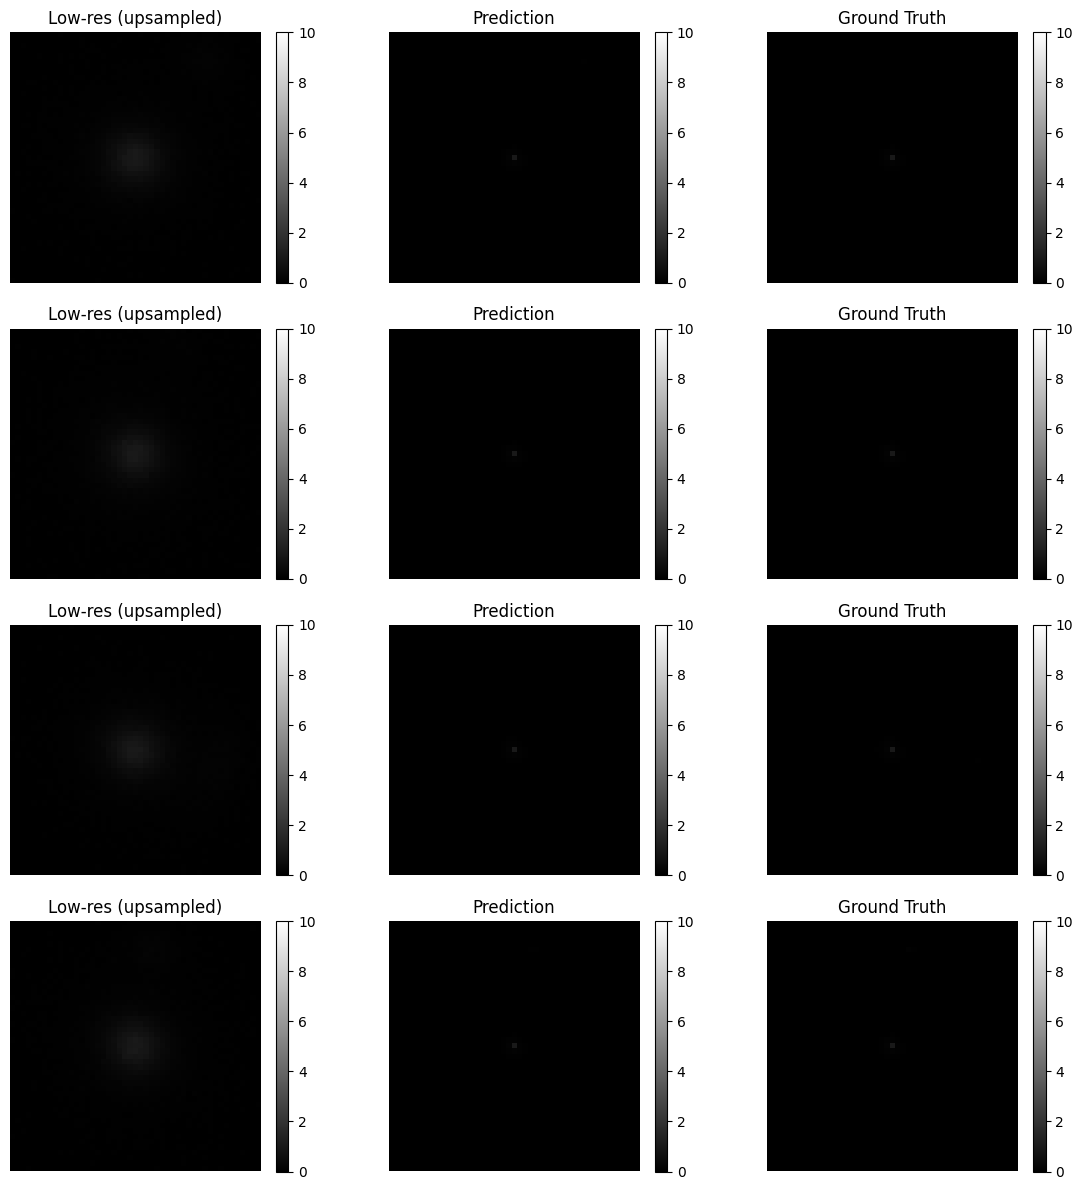

In [12]:
visualize_results(model, val_loader, n_samples=4, vmax=10)